**In this notebook, we will use SQUID to generate shape-similar analogues for a handful of 3D compounds from our test set.**


Before you run these cells, you will need to download some data from Figshare: https://figshare.com/s/3d2f8fd57d9a65fe237e


First, we import some modules.

In [ ]:
import torch_geometric
import torch
import torch_scatter
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import rdkit
import rdkit.Chem
import rdkit.Chem.AllChem
import rdkit.Chem.rdMolTransforms
import networkx as nx
import random
from tqdm import tqdm
from rdkit.Chem import rdMolTransforms
import itertools
import os
import pickle

import torch.nn as nn
import torch.nn.functional as F
from models.vnn.models.vn_layers import *
from models.vnn.models.utils.vn_dgcnn_util import get_graph_feature

from utils.general_utils import *

from models.EGNN import *
from models.models import *

We will now specify the following generation hyperparameters:

- The interpolation factor $\lambda$ controlling the degree of lienar interpolation between the posterior and prior
- The threshold for local stopping
- Scale factor to scale the standard deviation after interpolation (default is 1.0)
- Whether to ablate equivariance
    
We also specify some sampling limits. Here, we will generate 20 molecules for 10 different targets.


In [2]:
interpolate_to_GNN_prior = 1.0 # 'prior'
stop_threshold = 0.01
variational_GNN_factor = 1.0
ablateEqui = False

repetitions = 20
total_evaluations = 10 

We now load in some necessary data containing:
- The atom/fragment library
- bond distance lookup table
- array of unique atom types
- 3D molecules in the test set

In [3]:
use_artificial_mols = True

AtomFragment_database = pd.read_pickle('data/MOSES2/MOSES2_training_val_AtomFragment_database.pkl')
AtomFragment_database = AtomFragment_database.iloc[1:].reset_index(drop = True) # removing stop token from AtomFragment_database
fragment_library_atom_features = np.concatenate(AtomFragment_database['atom_features'], axis = 0).reshape((len(AtomFragment_database), -1))

bond_lookup = pd.read_pickle('data/MOSES2/MOSES2_training_val_bond_lookup.pkl')
unique_atoms = np.load('data/MOSES2/MOSES2_training_val_unique_atoms.npy') 

test_mol_df = pd.read_pickle('data/MOSES2/test_MOSES_filtered_artificial_mols.pkl')


We will encode 'artificial molecules' with fixed bonding geometries

In [4]:
test_mols = list(test_mol_df.artificial_mol)

and shuffle the test set...

In [5]:
random.seed(0)
indices_to_evaluate = list(range(0, len(test_mols)))
random.shuffle(indices_to_evaluate)

val_mols = [test_mols[i] for i in indices_to_evaluate]
val_mols_index = indices_to_evaluate

We will generate new molecules using our two trained models:
1. graph generator
2. rotatable bond scorer

In [6]:
if not ablateEqui:
    model_3D_PATH = 'trained_models/graph_generator.pt'
    rocs_model_3D_PATH = 'trained_models/scorer.pt'
else:
    model_3D_PATH = 'trained_models/graph_generator_ablateEqui.pt'
    rocs_model_3D_PATH = 'trained_models/scorer_ablateEqui.pt'

In [7]:
# HYPERPARAMETERS for 3D graph generator
pointCloudVar = 1. / (12. * 1.7) 

model_3D = Model_Point_Cloud_Switched(
    input_nf = 45, 
    edges_in_d = 5, 
    n_knn = 5, 
    conv_dims = [32, 32, 64, 128], 
    num_components = 64, 
    fragment_library_dim = 64, 
    N_fragment_layers = 3, 
    append_noise = False, 
    N_members = 125 - 1, 
    EGNN_layer_dim = 64, 
    N_EGNN_layers = 3, 
    output_MLP_hidden_dim = 64, 
    pooling_MLP = False, 
    shared_encoders = False, 
    subtract_latent_space = True,
    variational = False,
    variational_mode = 'inv', # not used
    variational_GNN = True,
    
    mix_node_inv_to_equi = True,
    mix_shape_to_nodes = True,
    ablate_HvarCat = False,
    
    predict_pairwise_properties = False,
    predict_mol_property = False,
    
    ablateEqui = ablateEqui,
    
    old_EGNN = False,
    
).float()

model_3D.load_state_dict(torch.load(model_3D_PATH, map_location=next(model_3D.parameters()).device), strict = True)
model_3D.eval()


# HYPERPARAMETERS for ROCS scorer
rocs_pointCloudVar = 1. / (12. * 1.7) 

rocs_model_3D = ROCS_Model_Point_Cloud(
    input_nf = 45, 
    edges_in_d = 5, 
    n_knn = 10, 
    conv_dims = [32, 32, 64, 128], 
    num_components = 64, 
    fragment_library_dim = 64,
    N_fragment_layers = 3, 
    append_noise = False, 
    N_members = 125 - 1, 
    EGNN_layer_dim = 64, 
    N_EGNN_layers = 3, 
    output_MLP_hidden_dim = 64, 
    pooling_MLP = False, 
    shared_encoders = False, 
    subtract_latent_space = True,
    variational = False,
    variational_mode = 'inv', # not used
    variational_GNN = False,
    
    mix_node_inv_to_equi = True,
    mix_shape_to_nodes = True,
    ablate_HvarCat = False,
    
    ablateEqui = ablateEqui,
    
    old_EGNN = False,
    
).float()

rocs_model_3D.load_state_dict(torch.load(rocs_model_3D_PATH, map_location=next(rocs_model_3D.parameters()).device), strict = True)
rocs_model_3D.eval()

ROCS_Model_Point_Cloud(
  (Encoder): Encoder_point_cloud(
    (fragment_encoder): FragmentLibraryEncoder(
      (EGNN_layers): ModuleList(
        (0): EGNN_static(
          (edge_mlp): Sequential(
            (0): Linear(in_features=96, out_features=64, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=64, out_features=64, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
          )
          (node_mlp): Sequential(
            (0): Linear(in_features=109, out_features=64, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=64, out_features=64, bias=True)
          )
        )
        (1): EGNN_static(
          (edge_mlp): Sequential(
            (0): Linear(in_features=193, out_features=64, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=64, out_features=64, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
          )
          (node_

Finally, we use the models to generate new 3D molecules conditioned on the target shape.
Here, we report the chemical similarity and the shape similarity before ROCS-alignment. 
If you have access to an Openeye license, we will compute the aligned shape similarities in the next cells.

We will generate 20*10 = 200 molecules total. Each molecule takes about 2-3 seconds to generate on a cpu, so this next cell
will run for a few minutes.

In [8]:
# muting noisy warnings
from rdkit import RDLogger
import warnings
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=Warning) 
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)


file_idx = 0

reference_mols_list = []
unaligned_mols_list = []

for m_idx, m_ in enumerate(val_mols):
    
    seed = 0
    random.seed(seed)
    np.random.seed(seed = seed)
    torch.manual_seed(seed)
    
    m = deepcopy(m_)
    
    mol = deepcopy(m)
    xyz = np.array(mol.GetConformer().GetPositions())
    center_of_mass = np.sum(xyz, axis = 0) / xyz.shape[0]
    xyz_centered = xyz - center_of_mass
    for i in range(0, mol.GetNumAtoms()):
        x,y,z = xyz_centered[i]
        mol.GetConformer().SetAtomPosition(i, Point3D(x,y,z))
    
    m = deepcopy(mol)
    
    mol_target = deepcopy(m)
    ring_fragments = get_ring_fragments(mol_target)
    all_possible_seeds = get_all_possible_seeds(mol_target, ring_fragments)
    terminal_seeds = filter_terminal_seeds(all_possible_seeds, mol_target)
    
    select_seeds = get_starting_seeds(mol_target, AtomFragment_database, fragment_library_atom_features, unique_atoms, bond_lookup)
    
    if len(select_seeds) == 0:
        continue
    
    random_seed_selection = random.randint(0, len(select_seeds) - 1)
    select_seeds = [select_seeds[random_seed_selection]] * repetitions
    
    repeated_rocs = []
    repeated_tanimoto = []
    
    reference_mols = []
    unaligned_mols = []
    
    
    for seed in select_seeds:

        mol = deepcopy(m)
        
        # extracting starting seed and preparing to generate
        
        frame_generation, frame_rocs = get_frame_terminalSeeds(mol, seed, AtomFragment_database, include_rocs = True)
        positions = list(frame_rocs.iloc[0].positions_before)
        start = 0
        for i in range(len(frame_generation)):
            if (set(frame_generation.iloc[i].partial_graph_indices) == set(positions)) & (frame_generation.iloc[i].next_atom_index == -1):
                start = i + 1
                break
        
        if len(frame_generation.iloc[0].partial_graph_indices) == 1: # seed is a terminal ATOM
            terminalSeed_frame = frame_generation.iloc[0:start].reset_index(drop = True)
                    
            sequence = get_ground_truth_generation_sequence(terminalSeed_frame, AtomFragment_database, fragment_library_atom_features)
                
            mol = deepcopy(terminalSeed_frame.iloc[0].rdkit_mol_cistrans_stereo)
            partial_indices = deepcopy(terminalSeed_frame.iloc[0].partial_graph_indices_sorted)
            
            final_partial_indices = deepcopy(terminalSeed_frame.iloc[-1].partial_graph_indices_sorted)
            ring_fragments = get_ring_fragments(mol)
            add_to_partial = [list(f) for p in final_partial_indices for f in ring_fragments if p in f]
            add_to_partial = [item for sublist in add_to_partial for item in sublist]
            final_partial_indices = list(set(final_partial_indices).union(add_to_partial))
                
            queue_indices = deepcopy(terminalSeed_frame.iloc[0].focal_indices_sorted)
            
            _, seed_mol, queue, positioned_atoms_indices, atom_to_library_ID_map, _, _, _ = generate_seed_from_sequence(sequence, mol, partial_indices, queue_indices, AtomFragment_database, unique_atoms, bond_lookup, stop_after_sequence = True)
    
            seed_node_features = getNodeFeatures(seed_mol.GetAtoms())
            
            for k in atom_to_library_ID_map:
                seed_node_features[k] = AtomFragment_database.iloc[atom_to_library_ID_map[k]].atom_features
                
            G = get_substructure_graph(mol, final_partial_indices)
            G_seed = get_substructure_graph(seed_mol, list(range(0, seed_mol.GetNumAtoms())), node_features = seed_node_features)
            nm = nx.algorithms.isomorphism.generic_node_match(['atom_features'], [None], [np.allclose])
            em = nx.algorithms.isomorphism.numerical_edge_match("bond_type", 1.0)
            GM = nx.algorithms.isomorphism.GraphMatcher(G, G_seed, node_match = nm, edge_match = em)
            assert GM.is_isomorphic()
            idx_map = GM.mapping
                
        else: # seed is a terminal FRAGMENT
            partial_indices = deepcopy(frame_generation.iloc[0].partial_graph_indices_sorted)
            final_partial_indices = partial_indices
            seed_mol = generate_conformer(get_fragment_smiles(mol, partial_indices))
            idx_map = get_reindexing_map(mol, partial_indices, seed_mol)
            positioned_atoms_indices = sorted([idx_map[f] for f in final_partial_indices])
            
            atom_to_library_ID_map = {} # no individual atoms yet generated
            queue = [0] # 0 can be considered the focal root node
    
        for i in final_partial_indices:
            x,y,z = mol.GetConformer().GetPositions()[i]
            seed_mol.GetConformer().SetAtomPosition(idx_map[i], Point3D(x,y,z)) 
        
        
        
        starting_queue = deepcopy(queue)
        try:
            _, updated_mol, _, _, _, N_rocs_decisions, _, _, _, chirality_scored = generate_3D_mol_from_sequence(
                sequence = [], 
                partial_mol = deepcopy(seed_mol), 
                mol = deepcopy(mol_target), 
                positioned_atoms_indices = deepcopy(positioned_atoms_indices), 
                queue = starting_queue, 
                atom_to_library_ID_map = deepcopy(atom_to_library_ID_map), 
                model = model_3D, 
                rocs_model = rocs_model_3D,
                AtomFragment_database = AtomFragment_database,
                unique_atoms = unique_atoms, 
                bond_lookup = bond_lookup,
                N_points = 5, 
                N_points_rocs = 5,
                stop_after_sequence = False,
                mask_first_stop = False,
                stochastic = False, 
                chirality_scoring = True,
                stop_threshold = stop_threshold,
                steric_mask = True,
                
                variational_factor_equi = 0.0,
                variational_factor_inv = 0.0, 
                interpolate_to_prior_equi = 0.0,
                interpolate_to_prior_inv = 0.0, 
                
                use_variational_GNN = True, 
                variational_GNN_factor = variational_GNN_factor, 
                interpolate_to_GNN_prior = interpolate_to_GNN_prior, 
                
                rocs_use_variational_GNN = False, 
                rocs_variational_GNN_factor = 0.0, 
                rocs_interpolate_to_GNN_prior = 0.0,
                
                pointCloudVar = pointCloudVar, 
                rocs_pointCloudVar = rocs_pointCloudVar,
            )
            
            pred_rocs = get_ROCS(torch.tensor(np.array(updated_mol.GetConformer().GetPositions())), torch.tensor(np.array(mol.GetConformer().GetPositions())))
            
            tanimoto = rdkit.DataStructs.FingerprintSimilarity(*[rdkit.Chem.RDKFingerprint(x) for x in [mol, updated_mol]])
                
            reference_mols.append(mol)
            unaligned_mols.append(updated_mol)
            
            repeated_rocs.append(pred_rocs.item())
            repeated_tanimoto.append(tanimoto)
            
        except Exception as e:
            print(f'error during 3D generation -- {e}')
            continue
    
    print(f'Encoded Molecule {file_idx + 1}:')
    print('(non-aligned) shape scores:', [np.round(r, 3) for r in repeated_rocs])
    print('tanimoto chemical similarity:', [np.round(r, 3) for r in repeated_tanimoto])
    print()
    file_idx += 1
    
    reference_mols_list.append(reference_mols[0])
    unaligned_mols_list.append(unaligned_mols)
    
    if file_idx == total_evaluations:
        break
    

Encoded Molecule 1:
(non-aligned) shape scores: [0.399, 0.645, 0.502, 0.713, 0.531, 0.587, 0.582, 0.601, 0.502, 0.622, 0.378, 0.576, 0.443, 0.645, 0.522, 0.792, 0.765, 0.536, 0.801, 0.491]
tanimoto chemical similarity: [0.261, 0.253, 0.271, 0.326, 0.285, 0.259, 0.289, 0.291, 0.368, 0.254, 0.191, 0.359, 0.274, 0.157, 0.237, 0.305, 0.291, 0.354, 0.349, 0.249]

Encoded Molecule 2:
(non-aligned) shape scores: [0.413, 0.533, 0.354, 0.484, 0.626, 0.499, 0.769, 0.567, 0.755, 0.737, 0.767, 0.781, 0.575, 0.635, 0.711, 0.729, 0.775, 0.704, 0.799, 0.472]
tanimoto chemical similarity: [0.338, 0.416, 0.155, 0.28, 0.278, 0.259, 0.454, 0.251, 0.203, 0.204, 0.266, 0.238, 0.262, 0.298, 0.307, 0.327, 0.346, 0.274, 0.237, 0.182]

Encoded Molecule 3:
(non-aligned) shape scores: [0.488, 0.54, 0.377, 0.793, 0.387, 0.545, 0.457, 0.701, 0.556, 0.513, 0.488, 0.484, 0.423, 0.731, 0.406, 0.345, 0.581, 0.627, 0.454, 0.526]
tanimoto chemical similarity: [0.271, 0.163, 0.128, 0.267, 0.297, 0.216, 0.18, 0.237, 0.275

If you have access to an OpenEye license (placed in the parent directory), we can now use ROCS to compute the (aligned) shape similarity between the generated molecules and the target molecular shape.

In [ ]:
# Note that we can safely ignore these aromaticity warnings.

from utils.openeye_utils import *

all_shape_similarity = []
for r, ref in enumerate(reference_mols_list):
    ROCS_out = ROCS_shape_overlap(unaligned_mols_list[r], ref)
    aligned_shape_similarity = [ROCS_out[i][1] for i in range(len(ROCS_out))]
    all_shape_similarity.append(aligned_shape_similarity)

In [10]:
# selecting the best generated molecules (by shape similarity to their respective targets) 

best_generated_indices = [np.argmax(s) for s in all_shape_similarity]
best_generated_mols = [unaligned_mols_list[i][best_generated_indices[i]] for i in range(len(best_generated_indices))]


We now can compare the encoded molecule (with the target shape) to the SQUID-generated molecules.

Although we will visualize the molecules in 2D, note that we encode/decode molecules in 3D.


In [11]:
from IPython.core.display import Image, display
from rdkit.Chem import Draw

def get_2D_mol(mol):
    mol_2D = deepcopy(mol)
    rdkit.Chem.rdDepictor.Compute2DCoords(mol_2D)
    return mol_2D

encoded, decoded
aligned shape similarity: 0.8706264928476455


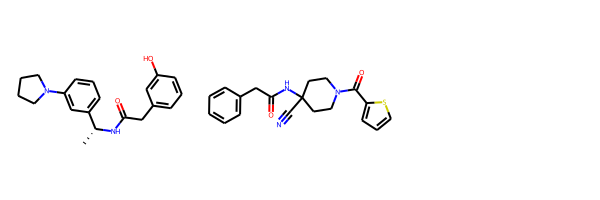

encoded, decoded
aligned shape similarity: 0.8426096427387321


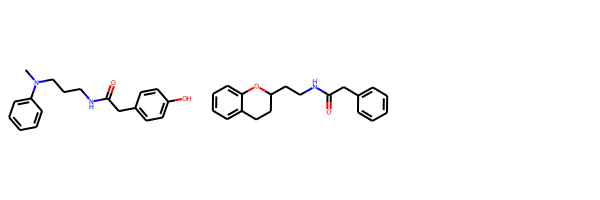

encoded, decoded
aligned shape similarity: 0.8269169602590691


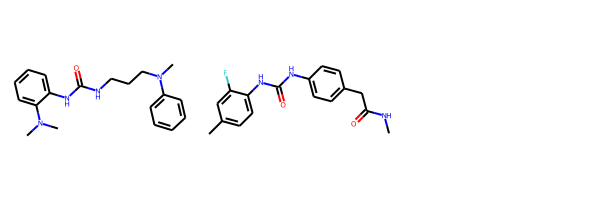

encoded, decoded
aligned shape similarity: 0.784029297579313


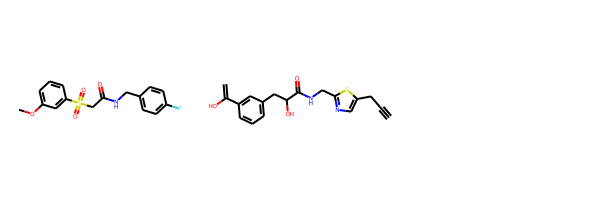

encoded, decoded
aligned shape similarity: 0.7881463164790653


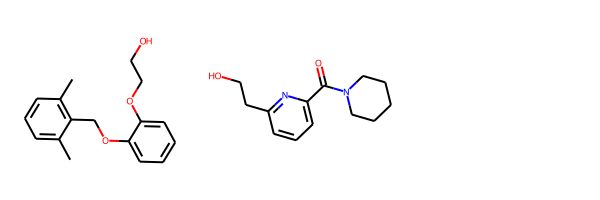

encoded, decoded
aligned shape similarity: 0.8460011299850846


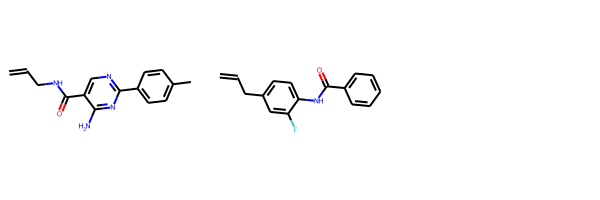

encoded, decoded
aligned shape similarity: 0.7455217055009342


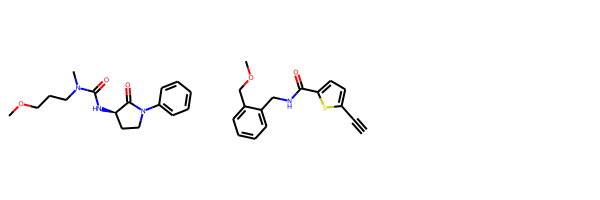

encoded, decoded
aligned shape similarity: 0.8530059142417641


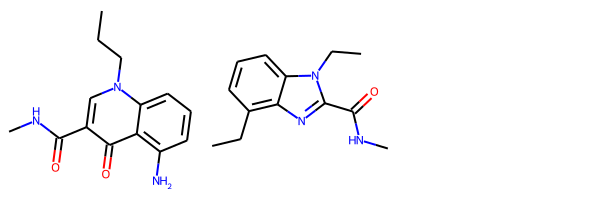

encoded, decoded
aligned shape similarity: 0.9316405575384616


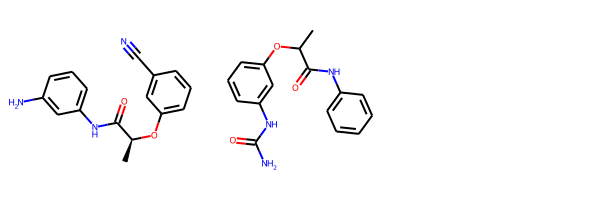

encoded, decoded
aligned shape similarity: 0.8097806553751086


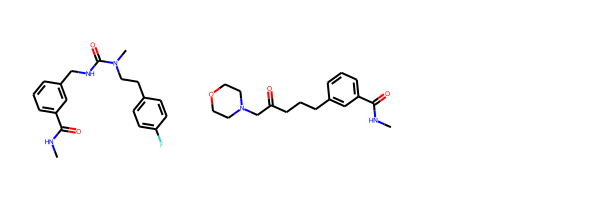

In [12]:
# Displaying most shape-similar molecules

for i in range(len(best_generated_mols)):
    print('encoded, decoded')
    print('aligned shape similarity:', all_shape_similarity[i][best_generated_indices[i]])
    
    display(Draw.MolsToGridImage([get_2D_mol(reference_mols_list[i]), get_2D_mol(best_generated_mols[i])]))
